# Intro
Name:  

    Aerosol_under_cloud_oxa_explore

Purpose:  

    Explore KORUS-AQ data to see if there are signals of aerosol to be exploited within the cloudy/cirrusy scenes. Relate to Oxygen-A band
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - Sp_parameters.py : for Sp class definition, and for defining the functions used to build parameters
    - matplotlib
    - mpltools
    - numpy
    - scipy : for saving and reading
    - plotting_utils (user defined plotting routines)
    - hdf5storage
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - starsun for KORUS-AQ
  
 Modification History:
 
     Written: by Samuel LeBlanc, Santa Cruz, Humble Sea, 2019-03-15

# Load the python modules and setup paths


In [92]:
import numpy as np
import hdf5storage as hs
import os
import write_utils as wu
import scipy.io as sio
import matplotlib.pyplot as plt
from mpltools import color

In [93]:
import load_utils as lu
from path_utils import getpath

In [94]:
%matplotlib notebook

In [95]:
import scipy.stats as st
import Sun_utils as su
import plotting_utils as pu

In [96]:
import Sp_parameters as sp
from scipy import interpolate

In [97]:
from linfit import linfit

In [98]:
fp = getpath('KORUS-AQ')

Return path named:  KORUS-AQ /mnt/c/Users/sleblanc/Research/KORUS-AQ/


In [99]:
daystr = '20160519'

# Load the starsun files

## Load the starsun file

In [12]:
s = sio.loadmat(fp+'data/{}starsun.mat'.format(daystr))

In [14]:
kk = s.keys()
kk.sort()
kk

['AZ_deg',
 'AZcorr',
 'AZstep',
 'Alt',
 'ELcorr',
 'El_deg',
 'Elstep',
 'Headng',
 'Lat',
 'Lon',
 'Md',
 'NO2col',
 'O3col',
 'O3h',
 'Pst',
 'QdVlr',
 'QdVtb',
 'QdVtot',
 'RH',
 'RHprecon',
 'RHprecon_percent',
 'Str',
 'Tbox',
 'Tbox_C',
 'Tprecon',
 'Tprecon_C',
 'Tst',
 'Zn',
 '__globals__',
 '__header__',
 '__version__',
 'aeronetcols',
 'aerosolcols',
 'c0',
 'c0err',
 'c0mod',
 'cwv',
 'dark',
 'darkstd',
 'f',
 'filename',
 'flight',
 'fwhm',
 'gas',
 'm_H2O',
 'm_NO2',
 'm_O3',
 'm_aero',
 'm_ray',
 'ng',
 'nirAVG',
 'nirTint',
 'nirVdettemp',
 'nirVdettemp_C',
 'nircols',
 'nirfilen',
 'nirheader',
 'nirrow_labels',
 'nirsat_pixel',
 'nirt',
 'note',
 'pitch',
 'program_version',
 'rate',
 'rateaero',
 'rateslant',
 'ratetot',
 'raw',
 'rawcorr',
 'roll',
 'sat_ij',
 'sat_time',
 'sd_aero_crit',
 'skyresp',
 'skyresperr',
 'sunaz',
 'sunel',
 'sza',
 't',
 'tau_CO2_CH4_N2O',
 'tau_CO2_CH4_N2O_abserr',
 'tau_NO2',
 'tau_NO2_err',
 'tau_O3',
 'tau_O3_err',
 'tau_O4',
 'tau

In [18]:
s['utc'] = lu.toutc(lu.mat2py_time(s['t']))

<IPython.core.display.Javascript object>


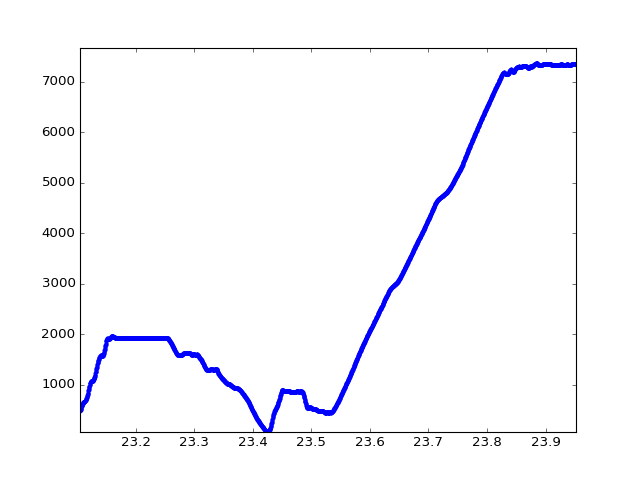

In [21]:
plt.plot(s['utc'],s['Alt'],'.')

In [22]:
tprofile = [23.5,23.8]

In [43]:
ip = (s['utc']>tprofile[0]) & (s['utc']<tprofile[1])

# Calculate the angstrom exponent

In [36]:
s['w'].shape

(1, 1556)

In [37]:
ja = np.argmin(abs(s['w']-0.470))

In [39]:
je = np.argmin(abs(s['w']-0.875))

In [41]:
s['w'][0,ja],s['w'][0,je]

(0.47018300000000002, 0.87467300000000003)

In [42]:
s['angs_470_865'] = []
for i,u in enumerate(s['utc']):
    to = np.log(s['tau_aero'][i,je])-np.log(s['tau_aero'][i,ja])
    bo = np.log(s['w'][0,je]*1000.0)-np.log(s['w'][0,ja]*1000.0)
    s['angs_470_865'].append(to/bo*-1.0)
s['angs_470_865'] = np.array(s['angs_470_865'])

<IPython.core.display.Javascript object>


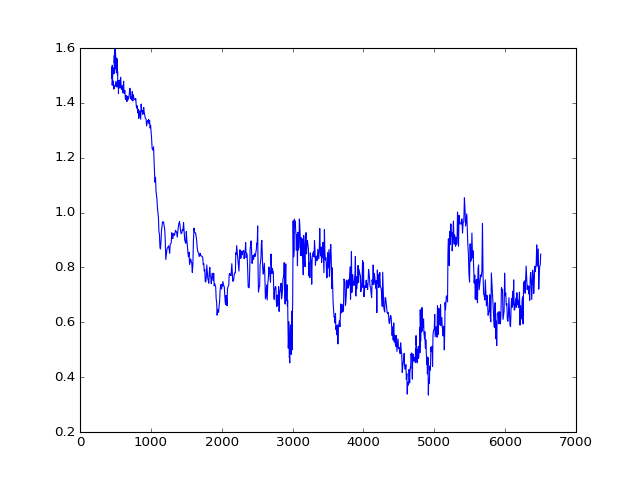

In [44]:
plt.figure()
plt.plot(s['Alt'][ip],s['angs_470_865'][ip])

# Calculate the oxygen-a band depth

<IPython.core.display.Javascript object>


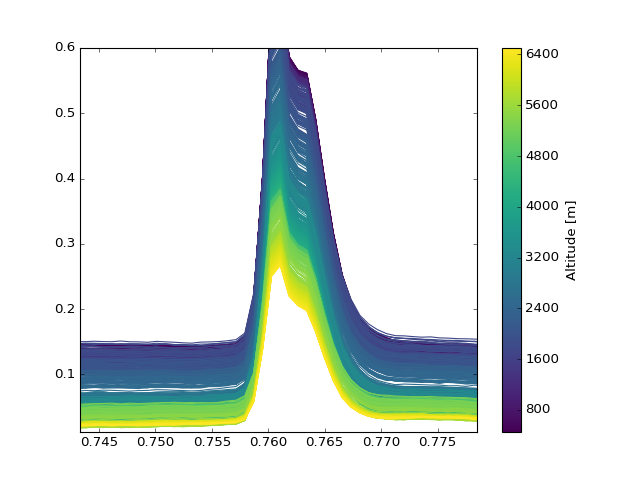

In [52]:
plt.figure()
color.cycle_cmap(len(s['Alt'][ip]),cmap=plt.cm.viridis,ax=plt.gca())
plt.plot(s['w'].T,s['tau_aero'][ip,:].T)
plt.ylim(0,0.6)
plt.xlim(0.35,0.8)
scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
scalarmap.set_array(s['Alt'][ip])
cba = plt.colorbar(scalarmap)
cba.set_label('Altitude [m]')

<IPython.core.display.Javascript object>


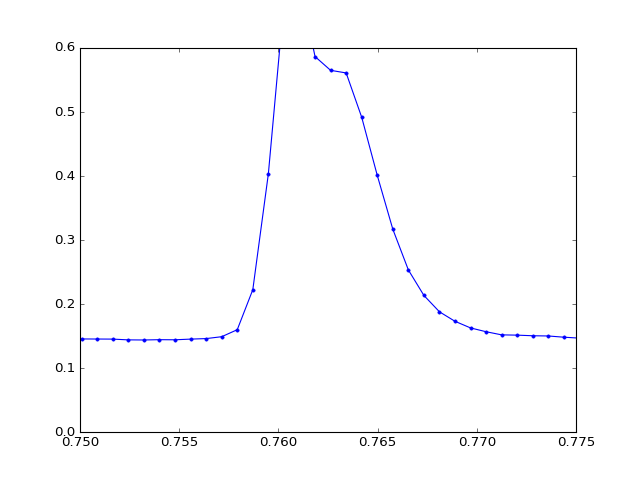

(0.75, 0.775)

In [61]:
plt.figure()
plt.plot(s['w'][0,:],s['tau_aero'][ip,:][0,:],'.-')
plt.ylim(0,0.6)
plt.xlim(0.75,0.775)

In [62]:
y0 = np.argmin(abs(s['w']-0.756))
y1 = np.argmin(abs(s['w']-0.772))

In [63]:

y0,y1

(729, 749)

In [72]:
s['oxa_flat'] = []
s['oxa_delta'] = []
for i,u in enumerate(s['utc']):
    fx = interpolate.interp1d(s['w'][0,[y0,y1]],s['tau_aero'][i,[y0,y1]])
    s['oxa_flat'].append(fx(s['w'][0,y0:y1]))
    s['oxa_delta'].append(np.nansum(s['tau_aero'][i,y0:y1]-s['oxa_flat']))

In [71]:
s['w'][0,y0:y1]

array([ 0.756357,  0.757141,  0.757926,  0.75871 ,  0.759494,  0.760279,
        0.761063,  0.761847,  0.762631,  0.763415,  0.764199,  0.764983,
        0.765767,  0.766551,  0.767334,  0.768118,  0.768901,  0.769685,
        0.770468,  0.771251])

<IPython.core.display.Javascript object>


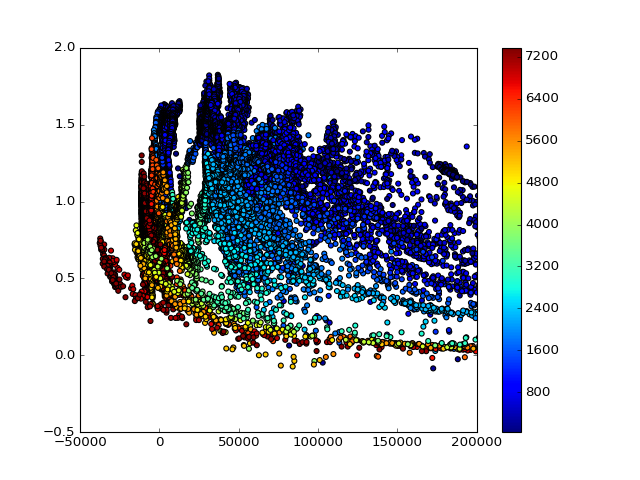

In [87]:
plt.figure()
plt.scatter(s['oxa_delta'],s['angs_470_865'],c=s['Alt'])
plt.xlim(-50000,200000)
plt.colorbar()

In [90]:
plt.figure()
plt.plot(s['oxa_delta']/s['Alt'],s['angs_470_865'],'.')
#plt.xlim(-50000,200000)
plt.colorbar()

<IPython.core.display.Javascript object>

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).